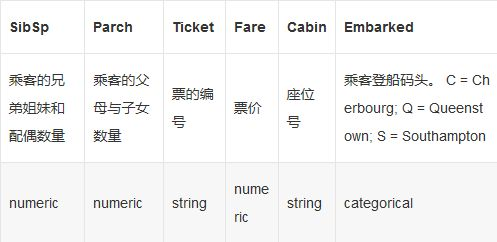
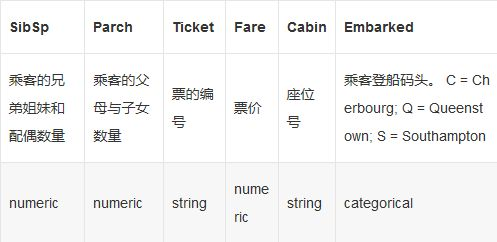

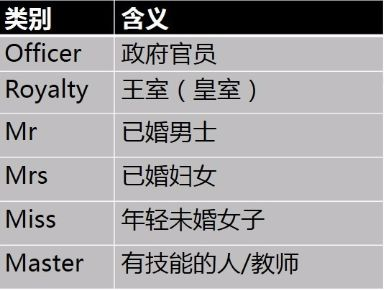

In [233]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split

train=pd.read_csv('/home/yuanbaoer/notebooks/Kaggle/data/train.csv')
test=pd.read_csv('/home/yuanbaoer/notebooks/Kaggle/data/test.csv')
all=train.append(test,ignore_index=True)#合并
all.info()
all.head()
#数据清洗 
#常用的缺失数据处理的几个方法：删除缺失数据；均值/中位数/众数插补;使用固定值;最近临插
#age项缺失过多,不能直接将其填充为众数或平均值:利用其他组特征量,age完整项作为训练集,缺失项作为测试集??
#根据Title项中的Mr、Master、Miss等称呼的平均年龄填充
#all['Age']=all.Age.fillna(all['Age'].mean())
all['Cabin']=all['Cabin'].fillna('U')#缺失过多
#按一二三等舱各自均价填充,家庭团体票 ,均分到个人?
#all['Fare']=all.Fare.fillna(all['Fare'].mean())
all['Fare']=all['Fare'].fillna(all['Fare'].groupby(all['Pclass']).transform('mean'))
print (all['Fare'].groupby(all['Pclass']).transform('mean'))
all.info()
all['Fare']=all['Fare']/all['Fare'].groupby(all['Ticket']).transform('count')

all['Embarked']=all['Embarked'].fillna(all['Embarked'].mode().iloc[0])
#all['Embarked']=all['Embarked'].fillna('S')
#机器没有办法直接识别字符串所代表的特征的:one-hot编码
sexdict={'male':1,'female':0}
all['Sex']=all['Sex'].map(sexdict)
embarked=pd.DataFrame()#港口
embarked=pd.get_dummies(all.Embarked,prefix='Embarked')
#all=pd.concat([all,embarked],axis=1)
pclass=pd.DataFrame()#船舱
pclass=pd.get_dummies(all.Pclass,prefix='Pclass')
#all=pd.concat([all,pclass],axis=1)
#姓名由名字\称谓\姓组成,切分字符串:例如：Braund, Mr. Owen Harris
def segment(name):
    str=name.split(',')[1]
    str1=str.split('.')[0]
    str2=str1.strip()
    return str2
a=all.loc[:,'Name']
titDf=pd.DataFrame()
titDf['title']=a.map(segment)
titDf.head()
#将称谓对应的头衔代入，并使用One-hot编码
title_mapDict = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }
titDf['title']=titDf['title'].map(title_mapDict)
all=pd.concat([all,titDf],axis=1)
#print (all.head())
#age根据对应title平均值填充
#print (all['Age'].groupby(all['title']).transform('mean'))
all['Age']=all['Age'].fillna(all['Age'].groupby(all['title']).transform('mean'))
#print (all.head())
all.info()
titDf=pd.get_dummies(titDf['title'])


#titDf.head()
#船舱号这一列取出船舱号的首字母代替
all['Cabin']=all['Cabin'].map(lambda c:c[0])
CabinDf=pd.get_dummies(all['Cabin'],prefix='Cabin')
#all=pd.concat([all,CabinDf],axis=1)
all.drop('Cabin',axis=1,inplace=True)
print(all.head())
#家庭成员
familyDf=pd.DataFrame()
familyDf['familysize']=all['Parch']+all['SibSp']+1
#家庭类别：
#小家庭Family_Single：家庭人数=1
#中等家庭Family_Small: 2<=家庭人数<=4
#大家庭Family_Large: 家庭人数>=5
def family_category(family):
    if family==1:
        return 0
    elif family<=4:
        return 1
    else:
        return 2

familyDf['family_category']=familyDf['familysize'].map(family_category)
#familyDf.drop('familysize',axis=1,inplace=True)
#all=pd.concat([all,familyDf],axis=1)
#all.drop('Parch',axis=1,inplace=True)
#all.drop('SibSp',axis=1,inplace=True)
all.head()

corrDf=pd.DataFrame()
corrDf=all.corr()
print(corrDf['Survived'].sort_values(ascending=False))

all.info()
all.drop('Ticket',axis=1,inplace=True)
all_x=pd.concat([titDf,pclass,all['Fare'],CabinDf,embarked,\
                 all['Sex'],familyDf,all['Age']],axis=1)
print (all_x.head())
trainrow=891
#trainx=all_x.loc[0:trainrow-1,:]
trainx=all_x.loc[0:trainrow-1,:]
trainx.head()
trainy=all.loc[0:trainrow-1,'Survived']
#predx=all_x.loc[trainrow:,:]
predx=all_x.loc[trainrow:,:]
print('train row',trainx.shape[0])#原始数据
print('test row',predx.shape[0])#测试数据
trainx.head()
#trainy.head()

train_X,test_X,train_y,test_y=train_test_split(trainx,trainy,train_size=0.8)
print('原始数据特征',trainx.shape,'训练数据特征',train_X.shape,'测试数据特征',test_X.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
0       13.302889
1       87.508992
2       13.302889
3       87.508992
4       13.302889
5       13.302889
6       87.508992
7       13.302889
8       13.302889
9       21.179196
10      13.302889
11      87.508992
12      13.302889
13      13.302889
14      13.302889
15      21.179196
16      13.302889
17      21.179196
18      13.302889
19      13.302889
20      21.179196
21      21.179196
22  

In [183]:
#from sklearn import RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.grid_search import GridSearchCV
import pandas as pd
from sklearn.metrics import classification_report
def get_top_n_features(trainx,trainy,topn):
    #随机森林
    rf_est=RandomForestClassifier(random_state=42)
    rf_param_grid={'n_estimators':[500],'min_samples_split':[2,3],'max_depth':[20]}
    rf_grid=GridSearchCV(rf_est,rf_param_grid,n_jobs=25,cv=10,verbose=1)
    rf_grid.fit(trainx,trainy)
    print(rf_grid.best_params_)
    #按特征重要性排序
    feature_imp_sorted_rf=pd.DataFrame({'feature':list(trainx),'importance':\
    rf_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_rf=feature_imp_sorted_rf.head(topn)['feature']
    print('sample features from rf')
    print(str(features_top_n_rf[:topn]))
    #y_true, y_pred = y_test, clf.predict(X_test)
    test_true,test_pred=test_y,rf_grid.predict(test_X)
    print(classification_report(test_true, test_pred))
    #AdaBoost
    ada_est=AdaBoostClassifier(random_state=42)
    ada_param_grid={'n_estimators':[500],'learning_rate':[0.5,0.6]}
    ada_grid=GridSearchCV(ada_est,ada_param_grid,n_jobs=25,cv=10,verbose=1)
    ada_grid.fit(train_X,train_y)
    feature_imp_sorted_ada=pd.DataFrame({'feature':list(trainx),'importance':\
    ada_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_ada=feature_imp_sorted_ada.head(topn)['feature']
    print('sample features from ada')
    print(str(features_top_n_ada[:topn]))
    test_true,test_pred=test_y,rf_grid.predict(test_X)
    print(classification_report(test_true, test_pred))
    #ExtraTree
    et_est=ExtraTreesClassifier(random_state=42)
    et_param_grid={'n_estimators':[500],'min_samples_split':[3,4],'max_depth':[15]}
    et_grid=GridSearchCV(et_est,et_param_grid,n_jobs=25,cv=10,verbose=1)
    et_grid.fit(train_X,train_y)
    feature_imp_sorted_et=pd.DataFrame({'feature':list(trainx),'importance':\
    et_grid.best_estimator_.feature_importances_}).sort_values('importance',ascending=False)
    features_top_n_et=feature_imp_sorted_ada.head(topn)['feature']
    print('sample features from et')
    print(str(features_top_n_et[:topn]))
    test_true,test_pred=test_y,rf_grid.predict(test_X)
    print(classification_report(test_true, test_pred))
    features_top_n=pd.concat([feature_imp_sorted_rf,feature_imp_sorted_ada[:topn],\
                              feature_imp_sorted_et],ignore_index=True).drop_duplicates()
    return(features_top_n)
feature_top_n=get_top_n_features(train_X,train_y,250)
feature_top_n.head()
#titanic__train_x=train_X[feature_top_n]
#titanic__test_x=test_X[feature_top_n]


#利用特征值重要性排名去除无用项



Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    7.4s remaining:    4.0s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    7.4s finished


{'max_depth': 20, 'min_samples_split': 3, 'n_estimators': 500}
sample features from rf
9                Fare
25                Age
2                  Mr
22                Sex
23         familysize
1                Miss
24    family_category
8            Pclass_3
3                 Mrs
18            Cabin_U
21         Embarked_S
6            Pclass_1
7            Pclass_2
19         Embarked_C
0              Master
20         Embarked_Q
4             Officer
13            Cabin_D
14            Cabin_E
12            Cabin_C
11            Cabin_B
10            Cabin_A
16            Cabin_G
15            Cabin_F
5             Royalty
17            Cabin_T
Name: feature, dtype: object
             precision    recall  f1-score   support

        0.0       0.84      0.92      0.88       112
        1.0       0.84      0.70      0.76        67

avg / total       0.84      0.84      0.83       179

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    8.1s remaining:    4.4s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    8.2s finished


sample features from ada
9                Fare
25                Age
23         familysize
3                 Mrs
22                Sex
4             Officer
14            Cabin_E
12            Cabin_C
24    family_category
21         Embarked_S
13            Cabin_D
7            Pclass_2
10            Cabin_A
16            Cabin_G
19         Embarked_C
6            Pclass_1
2                  Mr
11            Cabin_B
5             Royalty
0              Master
8            Pclass_3
17            Cabin_T
18            Cabin_U
1                Miss
15            Cabin_F
20         Embarked_Q
Name: feature, dtype: object
             precision    recall  f1-score   support

        0.0       0.84      0.92      0.88       112
        1.0       0.84      0.70      0.76        67

avg / total       0.84      0.84      0.83       179

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=25)]: Done  13 out of  20 | elapsed:    7.0s remaining:    3.8s
[Parallel(n_jobs=25)]: Done  20 out of  20 | elapsed:    7.0s finished


sample features from et
9                Fare
25                Age
23         familysize
3                 Mrs
22                Sex
4             Officer
14            Cabin_E
12            Cabin_C
24    family_category
21         Embarked_S
13            Cabin_D
7            Pclass_2
10            Cabin_A
16            Cabin_G
19         Embarked_C
6            Pclass_1
2                  Mr
11            Cabin_B
5             Royalty
0              Master
8            Pclass_3
17            Cabin_T
18            Cabin_U
1                Miss
15            Cabin_F
20         Embarked_Q
Name: feature, dtype: object
             precision    recall  f1-score   support

        0.0       0.84      0.92      0.88       112
        1.0       0.84      0.70      0.76        67

avg / total       0.84      0.84      0.83       179



,feature,importance
0,Fare,0.195341
1,Age,0.193929
2,Mr,0.139417
3,Sex,0.116985
4,familysize,0.056005


In [189]:
print (feature_top_n.shape)
train_X=train_X[feature_top_n['feature']]
train_X.info()
train_X.head()
#test_X=test_X[feature_top_n]

(78, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 694 to 559
Columns: 702 entries, Fare to Cabin_T
dtypes: float64(54), int64(81), uint8(567)
memory usage: 1.1 MB


,Fare,Fare,Fare,Fare,Fare,Fare,Fare,Fare,Fare,Age,...,Royalty,Cabin_T,Cabin_T,Cabin_T,Cabin_T,Cabin_T,Cabin_T,Cabin_T,Cabin_T,Cabin_T
694,26.55000,26.55000,26.55000,26.55000,26.55000,26.55000,26.55000,26.55000,26.55000,60.0,...,0,0,0,0,0,0,0,0,0,0
125,5.62085,5.62085,5.62085,5.62085,5.62085,5.62085,5.62085,5.62085,5.62085,12.0,...,0,0,0,0,0,0,0,0,0,0
258,128.08230,128.08230,128.08230,128.08230,128.08230,128.08230,128.08230,128.08230,128.08230,35.0,...,0,0,0,0,0,0,0,0,0,0
749,7.75000,7.75000,7.75000,7.75000,7.75000,7.75000,7.75000,7.75000,7.75000,31.0,...,0,0,0,0,0,0,0,0,0,0
605,7.77500,7.77500,7.77500,7.77500,7.77500,7.77500,7.77500,7.77500,7.77500,36.0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
#投票模型
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier 
rf_est=RandomForestClassifier(n_estimators=750,criterion='gini',max_features='sqrt',\
                             max_depth=3,min_samples_split=4,min_samples_leaf=2, n_jobs=50,\
                             random_state=42,verbose=1)
gbm_est=GradientBoostingClassifier(n_estimators=900,learning_rate=0.0008,loss='exponential',\
                                  min_samples_split=3,min_samples_leaf=2,max_features='sqrt',\
                                   max_depth=3,random_state=42,verbose=1)
et_est=ExtraTreesClassifier(n_estimators=750,max_features='sqrt',max_depth=35,n_jobs=50,\
                           criterion='entropy',random_state=42,verbose=1)
voting_est=VotingClassifier(estimators=[('rf', rf_est), ('gbm', gbm_est), ('et', et_est)], voting='soft',weights=[2,1,1])
voting_est.fit(trainx,trainy)
rf_est.fit(trainx,trainy)
gbm_est.fit(trainx,trainy)
et_est.fit(trainx,trainy)
print('rf score'+str(rf_est.score(trainx,trainy)))
print('gbm score'+str(gbm_est.score(trainx,trainy)))
print('et score'+str(et_est.score(trainx,trainy)))
print('voting score'+str(voting_est.score(trainx,trainy)))
print('votinh estimators'+str(voting_est.estimators_))



[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.2s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.5s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.8s finished


      Iter       Train Loss   Remaining Time 
         1           0.9724            2.33s
         2           0.9722            2.27s
         3           0.9719            2.33s
         4           0.9716            2.26s
         5           0.9713            2.36s
         6           0.9711            2.32s
         7           0.9708            2.33s
         8           0.9705            2.29s
         9           0.9702            2.18s
        10           0.9699            2.07s
        20           0.9670            1.40s
        30           0.9644            1.16s
        40           0.9620            1.03s
        50           0.9596            0.93s
        60           0.9566            0.87s
        70           0.9539            0.83s
        80           0.9511            0.78s
        90           0.9485            0.76s
       100           0.9457            0.73s
       200           0.9211            0.58s
       300           0.8987            0.49s
       40

[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.6s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    1.1s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.4s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.7s finished


      Iter       Train Loss   Remaining Time 
         1           0.9724            2.50s
         2           0.9722            2.33s
         3           0.9719            2.27s
         4           0.9716            2.27s
         5           0.9713            2.32s
         6           0.9711            2.26s
         7           0.9708            2.25s
         8           0.9705            2.24s
         9           0.9702            2.21s
        10           0.9699            2.24s
        20           0.9670            1.65s
        30           0.9644            1.34s
        40           0.9620            1.16s
        50           0.9596            1.06s
        60           0.9566            0.98s
        70           0.9539            0.92s
        80           0.9511            0.87s
        90           0.9485            0.83s
       100           0.9457            0.79s
       200           0.9211            0.73s
       300           0.8987            0.62s
       40

[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.4s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.8s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.2s finished


rf score0.8260381593714927
gbm score0.8047138047138047


[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.3s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s


et score0.9865319865319865


[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.3s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.2s


voting score0.9326599326599326
votinh estimators[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=50,
            oob_score=False, random_state=42, verbose=1, warm_start=False), GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0008, loss='exponential', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=2, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=900,
              presort='auto', random_state=42, subsample=1.0, verbose=1,
              warm_start=False), ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion

[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.3s finished


In [147]:
#模型构建
from sklearn.linear_model import LogisticRegression#逻辑回归
from sklearn.cross_validation import KFold
model=LogisticRegression()
#kf=KFold(trainx.shape[0],n_folds=3,random_state=1)

model.fit(train_X,train_y)
model.score(test_X,test_y)

0.8324022346368715

In [235]:
#预测
#trainx.head()
print (predx.head())
predx.info()
#predx=predx.drop(['Survived'],axis=1)
predy=voting_est.predict(predx)
predy=predy.astype('int')
submission=pd.DataFrame({'PassengerId':test.loc[:,'PassengerId'],'Survived':predy})
submission.to_csv('submission.csv',index=False,sep=',')


     Master  Miss  Mr  Mrs  Officer  Royalty  Pclass_1  Pclass_2  Pclass_3  \
891       0     0   1    0        0        0         0         0         1   
892       0     0   0    1        0        0         0         0         1   
893       0     0   1    0        0        0         0         1         0   
894       0     0   1    0        0        0         0         0         1   
895       0     0   0    1        0        0         0         0         1   

        Fare  ...   Cabin_G  Cabin_T  Cabin_U  Embarked_C  Embarked_Q  \
891  7.82920  ...         0        0        1           0           1   
892  7.00000  ...         0        0        1           0           0   
893  9.68750  ...         0        0        1           0           1   
894  8.66250  ...         0        0        1           0           0   
895  6.14375  ...         0        0        1           0           0   

     Embarked_S  Sex  familysize  family_category   Age  
891           0    1           1  

[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.2s finished
[Parallel(n_jobs=50)]: Done 100 tasks      | elapsed:    0.0s
[Parallel(n_jobs=50)]: Done 350 tasks      | elapsed:    0.1s
[Parallel(n_jobs=50)]: Done 750 out of 750 | elapsed:    0.2s finished


In [143]:
df = pd.DataFrame({'A': [1, 2, 1, 2, 1, 2, 3]})
df.mode().iloc[0]


A    1
Name: 0, dtype: int64

In [122]:
#all['Embarked'].mode().iloc[0]
#all['Group_ticket']=pd.DataFrame()
#all['Fare'].groupby(all['Ticket']).transform('count')

#all['Fare']/all['Group_ticket']
#all['Fare'].groupby(all['Pclass']).mean().get([1]).values[0]
all['Age'].fillna(all['Age'].groupby('title').transform('mean'))

KeyError: 'title'

OrderedDict([('time', [0.5, 0.75, 1, 1.25, 1.5, 1.75, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 4, 4.25, 4.5, 4.75, 5, 5.5]), ('pass', [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])])


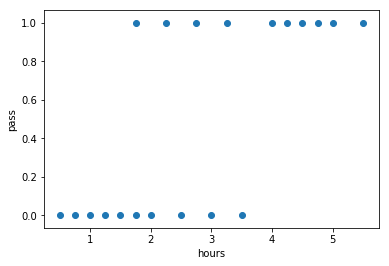

In [240]:
from collections import OrderedDict
import pandas as pd
#创建有序数据集合
examDict={'time':[0.5,0.75,1,1.25,1.5,1.75,1.75,2,2.25,
                 2.5,2.75,3,3.25,3.5,4,4.25,4.5,4.75,5,5.5],
         'pass':[0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1]}
examOrderDict=OrderedDict(examDict)#根据放入元素先后顺序排序
examDf=pd.DataFrame(examOrderDict)
print(examOrderDict)
examDf.head()
exam_x=examDf.loc[:,'time']
exam_y=examDf.loc[:,'pass']
 #绘制散点图
import matplotlib.pyplot as plt
plt.scatter(exam_x,exam_y,label='exam data')
plt.xlabel('hours')
plt.ylabel('pass')
plt.show()
from sklearn.cross_validation import train_test_split
#建立训练数据测试数据
x_train,x_test,y_train,y_test=train_test_split(exam_x,exam_y,train_size=0.8)
print('原始数据特征',exam_x.shape,
     '训练数据特征',x_train.shape,
     '测试数据特征',x_test.shape)
print('原始数据特征',exam_y.shape)
